## Imports

In [209]:
# !pip install imbalanced-learn
# !pip install xgboost

In [77]:
import os
import pandas as pd
import numpy as np
import hashlib
import io
import json
import pickle
import requests
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import ks_2samp
from plotchecker import LinePlotChecker, ScatterPlotChecker, BarPlotChecker
import seaborn as sns
import requests

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error


import lightgbm as lgb

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler
# from xgboost import XGBRegressor
# from imblearn.pipeline import Pipeline as ImbPipeline  # Use imbalanced-learn's pipeline

# from sklearn.base import BaseEstimator, TransformerMixin

In [32]:
# ## Know which packages i have installed
# !pip freeze

## Functions

In [78]:
def grouped_weighted_mape_bias(df, group_cols, y_true_col, y_pred_col, quantity_col):
    # Function to compute weighted MAPE & BIAS
    grouped = df.groupby(group_cols).apply(lambda g: pd.Series({
        "mape": np.sum(np.abs(g[y_true_col] - g[y_pred_col]) * g[quantity_col]) / np.sum(g[y_true_col] * g[quantity_col]),
        "bias": np.sum((g[y_pred_col] - g[y_true_col]) * g[quantity_col]) / np.sum(g[quantity_col])
    }), include_groups=False)
    
    return grouped.reset_index()

In [79]:
def plot_feature_importance(model, feature_names, title):
    """Plots feature importance from LightGBM model after preprocessing"""

    # Extract LightGBM feature importance
    importance = model.named_steps["model"].feature_importances_

    # Ensure feature names align with importance array
    if len(feature_names) != len(importance):
        print(f"Warning: Feature name length ({len(feature_names)}) does not match importance length ({len(importance)}). Adjusting...")
        feature_names = feature_names[:len(importance)]  # Trim feature names if mismatch occurs

    # Create DataFrame
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by="importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 10))
    sns.barplot(data=importance_df, x="importance", y="feature", hue="feature", legend=False, palette="coolwarm")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()



## Read data

In [82]:
dtype_dict = {
    'structure_level_4': 'object',
    'structure_level_3': 'object',
    'structure_level_2': 'object',
    'structure_level_1': 'object',
    'sku': 'int64',
    'competitor': 'object',
    'chain_campaign': 'object',
    'quantity': 'float64',
    'pvp_was': 'float64',
    'discount': 'float64',
    'flag_promo': 'float64',
    'leaflet': 'object',
    'pvp_is': 'float64',
    'flg_filled_gap': 'float64',
    'month': 'int32',
    'day_of_week': 'int32',
    'week_of_month': 'int64',
    'holiday': 'object',
    'holiday_importance': 'int64',
    'apparent_temperature_mean': 'int64',
    'precipitation_sum': 'int64',
    'abc': 'object',
    'seil': 'object',
    'xyz': 'object',
    'pvp_is_lag_1': 'float64',
    'pvp_is_lag_7': 'float64',
    'pvp_is_lag_30': 'float64',
    'discount_lag_1': 'float64',
    'discount_lag_7': 'float64',
    'discount_lag_30': 'float64',
    'days_since_last_promo': 'float64',
    'rolling_mean_7': 'float64',
    'rolling_mean_30': 'float64',
    'avg_discount_w_L3': 'float64',
    'promo_part_w_L3': 'float64',
    'avg_discount_w_sku': 'float64',
    'promo_part_w_sku': 'float64',
    'discount_chain': 'float64',
    'leaflet_chain': 'object'
}

In [83]:
df_input = pd.read_csv("prepared_data/data.csv",dtype=dtype_dict, parse_dates=['date'])
df_input['avg_discount_w_L3'] = df_input['avg_discount_w_L3'].round(2)
df_input['promo_part_w_L3'] = df_input['promo_part_w_L3'].round(2)
df_input['avg_discount_w_sku'] = df_input['avg_discount_w_sku'].round(2)
df_input['promo_part_w_sku'] = df_input['promo_part_w_sku'].round(2)

df = df_input[['sku', 'date','competitor', ## keys
         'pvp_is', ## target 
         'quantity', ## used for evaluation
         ## features:
         'structure_level_2', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
         'chain_campaign', 'holiday_importance',
         'month', 'day_of_week', 'week_of_month',
         'apparent_temperature_mean', 'precipitation_sum', 'avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
         'abc', 'seil', 'xyz', 'days_since_last_promo', 'discount_lag_7', 'pvp_is_lag_7',
          'discount_chain', 'leaflet_chain']]

#  'pvp_was' 'discount', 'flag_promo', 'leaflet'  flg_filled_gap 'pvp_is_lag_1', 'pvp_is_lag_7', 'pvp_is_lag_30', 'rolling_mean_7' 'rolling_mean_30' holiday

In [28]:
df_input.loc[((df_input.sku==3578) & (df_input.date=='2024-03-01'))].to_csv("test_sku_3578_2.csv")

In [38]:
df.head()

,sku,date,competitor,pvp_is,quantity,structure_level_2,chain_campaign,holiday_importance,month,day_of_week,...,precipitation_sum,avg_discount_w_L3,promo_part_w_L3,avg_discount_w_sku,promo_part_w_sku,abc,seil,xyz,discount_chain,leaflet_chain
0,1128,2023-01-03,competitorA,76.2,0.0,302,NaN,0,1,1,...,0,0.28,0.16,0.0,0.0,C,lumpy,Z,0.0,NaN
1,1128,2023-01-04,competitorA,76.2,0.0,302,NaN,0,1,2,...,0,0.28,0.16,0.0,0.0,C,lumpy,Z,0.0,NaN
2,1128,2023-01-05,competitorA,76.2,0.0,302,NaN,0,1,3,...,0,0.28,0.16,0.0,0.0,C,lumpy,Z,0.0,NaN
3,1128,2023-01-06,competitorA,76.2,0.0,302,NaN,0,1,4,...,0,0.28,0.16,0.0,0.0,C,lumpy,Z,0.0,NaN
4,1128,2023-01-07,competitorA,76.2,0.0,302,NaN,0,1,5,...,38,0.28,0.16,0.0,0.0,C,lumpy,Z,0.0,NaN


## Modelling

### Baseline -> consider always the last pvp_was

In [16]:
## Add pvp_was_lag
df_input[f"pvp_was_lag_1"] = df_input.groupby(["sku", "competitor"])["pvp_was"].shift(1)

# Filter data for CompetitorA and CompetitorB
df_compA = df_input[df_input["competitor"] == "competitorA"].copy()
df_compB = df_input[df_input["competitor"] == "competitorB"].copy()

# Define train-test split date (e.g., last 4 months for testing)
train_cutoff = pd.to_datetime("2024-06-04")  

df_compA_train = df_compA[df_compA["date"] < train_cutoff]
df_compA_test = df_compA[df_compA["date"] >= train_cutoff]
df_compB_train = df_compB[df_compB["date"] < train_cutoff]
df_compB_test = df_compB[df_compB["date"] >= train_cutoff]

df_compA_train = df_compA_train.sort_values(by=['sku', 'date'])
df_compB_train = df_compB_train.sort_values(by=['sku', 'date'])

# Get the last pvp_was for each SKU (latest date per sku)
df_last_pvp_was_A = df_compA_train.groupby('sku').tail(1).reset_index(drop=True)[['sku', 'pvp_was']].rename(columns={"pvp_was":"pvp_is_pred"})
df_last_pvp_was_B = df_compB_train.groupby('sku').tail(1).reset_index(drop=True)[['sku', 'pvp_was']].rename(columns={"pvp_was":"pvp_is_pred"})

In [17]:
df_preds_baseline_A = df_compA.copy()
df_preds_baseline_A = (df_preds_baseline_A.merge(df_last_pvp_was_A, on=['sku'], how='left'))

df_preds_baseline_B = df_compB.copy()
df_preds_baseline_B = (df_preds_baseline_B.merge(df_last_pvp_was_B, on=['sku'], how='left'))

# Combine competitor predictions
df_preds_baseline = pd.concat([df_preds_baseline_A, df_preds_baseline_B])

In [18]:
result_1 = grouped_weighted_mape_bias(df_preds_baseline, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
print("Weighted MAPE & BIAS by structure:\n", result_1)

Weighted MAPE & BIAS by structure:
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.131811  1.882359
1                 1  competitorB  0.114195  1.492358
2                 2  competitorA  0.123169  1.958384
3                 2  competitorB  0.116081  0.641929
4                 3  competitorA  0.103178  2.183898
5                 3  competitorB  0.065196  0.787653


### LGBRegressor

#### Pipeline

In [19]:
# Filter data for CompetitorA and CompetitorB
df_compA = df[df["competitor"] == "competitorA"].copy()
df_compB = df[df["competitor"] == "competitorB"].copy()

In [225]:
# Exclude keys + target variable
excluded_cols = ["sku", "date", "competitor", "pvp_is", "quantity"]

# # Competitor A
# X_compA = df_compA.drop(columns=excluded_cols)
# y_compA = df_compA["pvp_is"]
# X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_compA, y_compA, test_size=0.2, shuffle=False, random_state=42)

# # Competitor B
# X_compB = df_compB.drop(columns=excluded_cols)
# y_compB = df_compB["pvp_is"]
# X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_compB, y_compB, test_size=0.2, shuffle=False, random_state=42)

# Define train-test split date (e.g., last 4 months for testing)
train_cutoff = pd.to_datetime("2024-06-04")  

df_compA_train = df_compA[df_compA["date"] < train_cutoff]
X_train_A = df_compA_train.drop(columns=excluded_cols)
y_train_A = df_compA_train["pvp_is"]

df_compA_test = df_compA[df_compA["date"] >= train_cutoff]
X_test_A = df_compA_test.drop(columns=excluded_cols)
y_test_A = df_compA_test["pvp_is"]

df_compB_train = df_compB[df_compB["date"] < train_cutoff]
X_train_B = df_compB_train.drop(columns=excluded_cols)
y_train_B = df_compB_train["pvp_is"]

df_compB_test = df_compB[df_compB["date"] >= train_cutoff]
X_test_B = df_compB_test.drop(columns=excluded_cols)
y_test_B = df_compB_test["pvp_is"]

In [228]:
# Define categorical & continuous features
# categorical_features = ["chain_campaign", "leaflet", "holiday", "abc", "seil", "xyz", "leaflet_chain"]
# continuous_features = ["discount", "quantity", "pvp_was", "flag_promo", "holiday_importance",
#                        "apparent_temperature_mean", "precipitation_sum", "discount_chain",
#                        "month", "day_of_week", "week_of_month", "pvp_is_lag_1", "pvp_is_lag_7", "pvp_is_lag_30",
#                        "rolling_mean_7", "rolling_mean_30"]
categorical_features = ["chain_campaign", "abc", "seil", "xyz", 'structure_level_2', 'leaflet_chain']
continuous_features = ["holiday_importance",
                       "apparent_temperature_mean", "precipitation_sum", 
                       "month", "day_of_week", "week_of_month", 'discount_chain']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), continuous_features)
    ]
)

#### Hyperparameter Tunning

In [229]:
# Define hyperparameter grid (prefix parameters with 'model__')
param_grid = {
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [3, 5, 7],
    "model__num_leaves": [20, 31, 40],
}

# Train CompetitorA Model
pipeline_A = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42))])
random_search_A = RandomizedSearchCV(pipeline_A, param_grid, n_iter=3, cv=20, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42)
random_search_A.fit(X_train_A, y_train_A)
best_params_A = random_search_A.best_params_
print("Best Parameters for CompetitorA:", best_params_A)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 1266741, number of used features: 38
[LightGBM] [Info] Start training from score 50.242929
Best Parameters for CompetitorA: {'model__num_leaves': 31, 'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.01}


In [230]:
# Train CompetitorB Model
pipeline_B = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42))])
random_search_B = RandomizedSearchCV(pipeline_B, param_grid, n_iter=3, cv=20, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42)
random_search_B.fit(X_train_B, y_train_B)
best_params_B = random_search_B.best_params_
print("Best Parameters for CompetitorB:", best_params_B)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 464512, number of used features: 34
[LightGBM] [Info] Start training from score 43.009710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [231]:
df_compA_input = df_input[df_input["competitor"] == "competitorA"].copy()
df_compB_input = df_input[df_input["competitor"] == "competitorB"].copy()

In [232]:
# CompetitorA - Predictions
best_model_A = random_search_A.best_estimator_
y_pred_A = best_model_A.predict(X_test_A)

# CompetitorB - Predictions
best_model_B = random_search_B.best_estimator_
y_pred_B = best_model_B.predict(X_test_B)

# Create final dataset with predictions
final_preds_A = df_compA_input.loc[X_test_A.index].copy()
final_preds_A["pvp_is_pred"] = y_pred_A

final_preds_B = df_compB_input.loc[X_test_B.index].copy()
final_preds_B["pvp_is_pred"] = y_pred_B

# Combine competitor predictions
final_preds = pd.concat([final_preds_A, final_preds_B])

#### Evaluate

##### MAPE and BIAS

In [234]:
result_1 = grouped_weighted_mape_bias(final_preds, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
print("Weighted MAPE & BIAS by structure:\n", result_1)

Weighted MAPE & BIAS by structure:
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.454812  7.009797
1                 1  competitorB  0.428547  5.798121
2                 2  competitorA  0.411412  7.262631
3                 2  competitorB  0.395526  0.606747
4                 3  competitorA  0.420708  5.071418
5                 3  competitorB  0.375530  4.204848


C:\Users\catar\AppData\Local\Temp\ipykernel_16020\297204991.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(group_cols).apply(lambda g: pd.Series({


##### Feature Importance

C:\Users\catar\AppData\Local\Temp\ipykernel_16020\2751327770.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="importance", y="feature", palette="coolwarm")


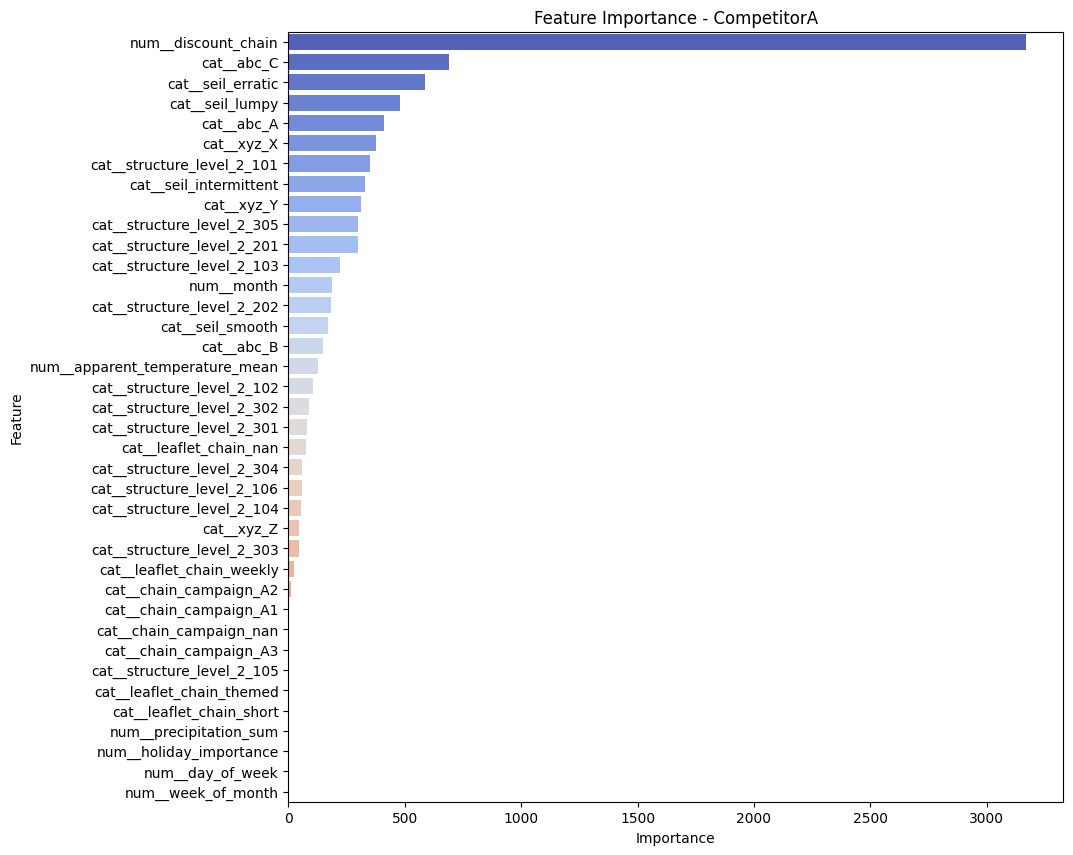

In [239]:
# Transform training data with preprocessing pipeline
X_train_transformed_A = best_model_A.named_steps["preprocessor"].transform(X_train_A)
X_train_transformed_B = best_model_B.named_steps["preprocessor"].transform(X_train_B)

# Extract correct feature names after transformation
feature_names_A = best_model_A.named_steps["preprocessor"].get_feature_names_out()
feature_names_B = best_model_B.named_steps["preprocessor"].get_feature_names_out()

# Plot feature importance for CompetitorA
plot_feature_importance(best_model_A, feature_names_A, "Feature Importance - CompetitorA")


C:\Users\catar\AppData\Local\Temp\ipykernel_16020\2751327770.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="importance", y="feature", palette="coolwarm")


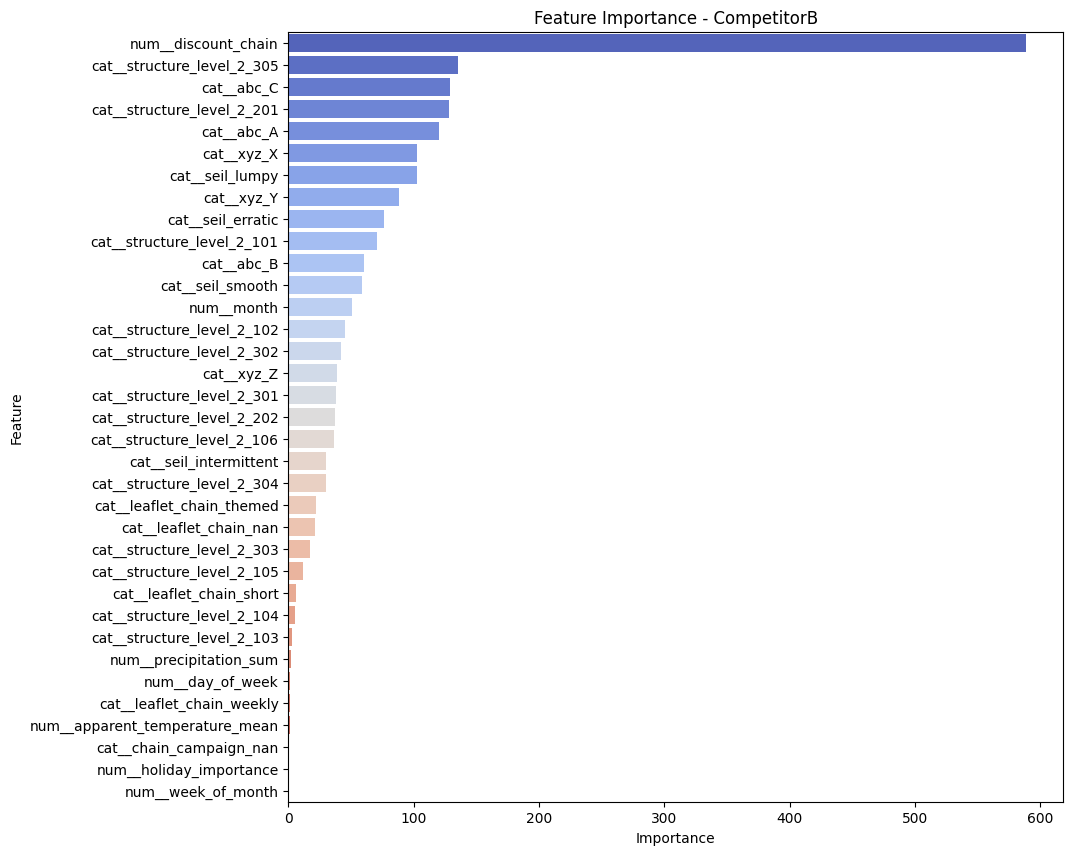

In [240]:
# Plot feature importance for CompetitorB
plot_feature_importance(best_model_B, feature_names_B, "Feature Importance - CompetitorB")

#### In loop

In [41]:
list_structure_level_1=df_input['structure_level_1'].sort_values().unique()
list_competitor=df_input['competitor'].sort_values().unique()

In [25]:
df = df_input[['sku', 'date','competitor', ## keys
                'pvp_is', ## target 
                'quantity', ## used for evaluation
                ## features:
                'structure_level_3', 'structure_level_1', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
                'chain_campaign', 'holiday_importance','avg_discount_w_L3','promo_part_w_L3',
                'month', 'day_of_week', 'week_of_month',
                'apparent_temperature_mean', 'precipitation_sum', 
                'abc', 'seil', 'xyz',
                'discount_chain', 'leaflet_chain']]

In [26]:
list_structure_level_1 = ['1']

***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorA
df_it:  346095

 Best Parameters for  competitorA  and structure_level_1  1 : 
 {'model__num_leaves': 20, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.01}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  1 : 
   structure_level_1   competitor      mape       bias
0                 1  competitorA  0.496836  10.474588

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape       bias
0               101  competitorA  0.527432  10.875129
1               102  competitorA  0.423404   8.306004
2               103  competitorA  0.591957  14.436995
3               104  competitorA  0.167613  -3.096421
4               105  competitorA  0.375091   3.835039
5               106  competitorA  0.245083   5.497030

 Feature Importance:


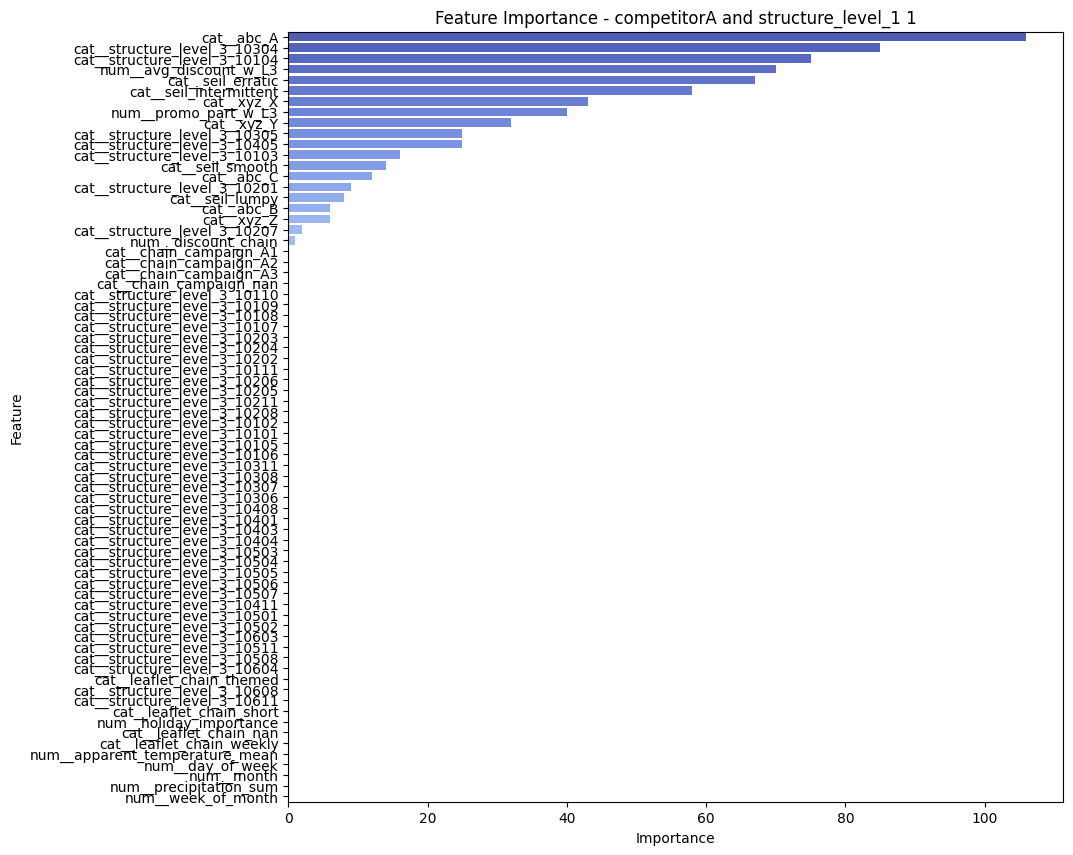

Model  final_model_it_structL1_1_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorB
df_it:  220328

 Best Parameters for  competitorB  and structure_level_1  1 : 
 {'model__num_leaves': 20, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.01}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorB  0.376607  6.424852

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorB  0.396958  6.700477
1               102  competitorB  0.329485  4.539900
2               103  competitorB  0.417729  8.871070
3               104  competitorB  0.155453  2.578274
4               105  competitorB  0.407641  9.710951
5               106  competitorB  0.213868  5.57297

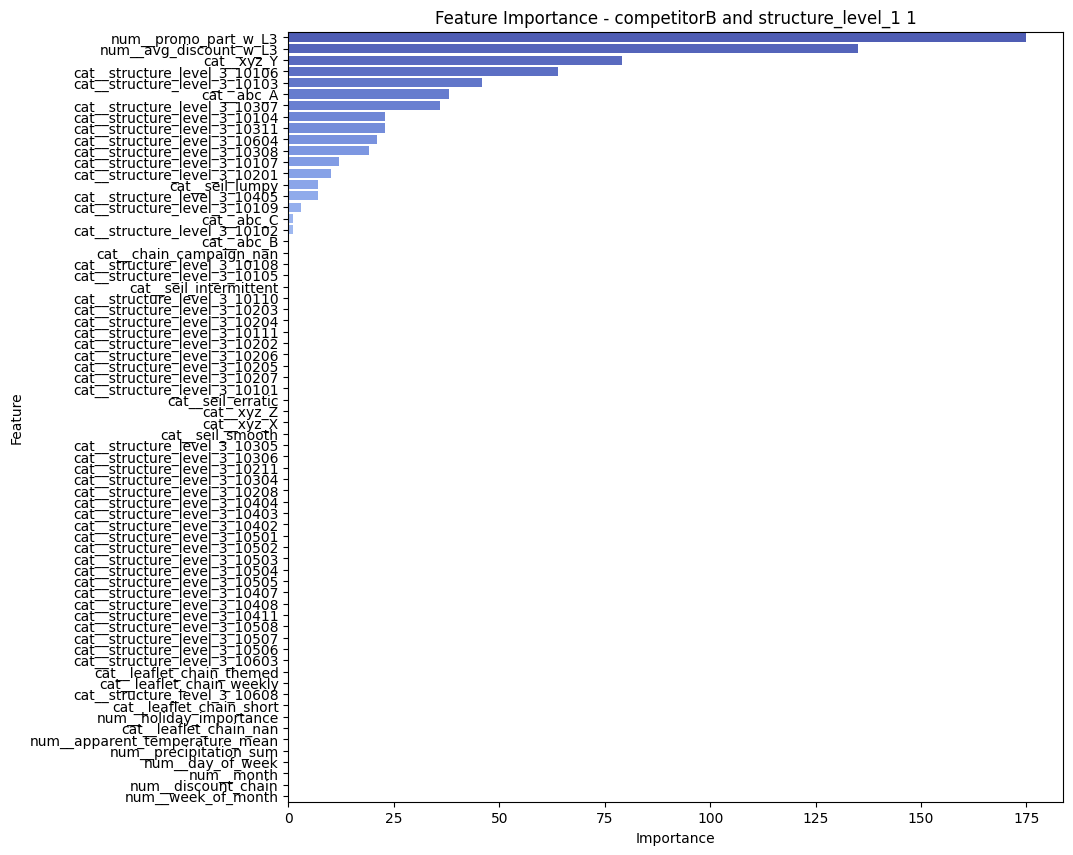

Model  final_model_it_structL1_1_competitorB.pickle  saved in ' models '




In [34]:
## Train a model for each competitor and structure of level 1

for struct1 in list_structure_level_1:
    for comp in list_competitor:
        print("***************************************************************************************************")
        print("Structure_level_1: ", struct1)
        print("Competitor: ", comp)

        ## 1. Filter dataset
        df_it = df[((df["competitor"] == comp) & (df["structure_level_1"]==struct1))].copy()
        df_it = df_it.drop('structure_level_1', axis=1)
        print("df_it: ", len(df_it))


        ## 2. Define train-test split date (e.g., last 4 months for testing)
        excluded_cols = ["sku", "date", "competitor", "pvp_is", "quantity"]
        train_cutoff = pd.to_datetime("2024-06-04")  
        df_it_train = df_it[df_it["date"] < train_cutoff]
        X_train_it = df_it_train.drop(columns=excluded_cols)
        y_train_it = df_it_train["pvp_is"]
        df_it_test = df_it[df_it["date"] >= train_cutoff]
        X_test_it = df_it_test.drop(columns=excluded_cols)
        y_test_it = df_it_test["pvp_is"]

        ## 3. Apply Transformations
        categorical_features = ["chain_campaign", "abc", "seil", "xyz", 'structure_level_3', 'leaflet_chain']
        continuous_features = ["holiday_importance",
                            "apparent_temperature_mean", "precipitation_sum", 
                            "month", "day_of_week", "week_of_month", 'discount_chain', 'avg_discount_w_L3','promo_part_w_L3']

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                ("num", StandardScaler(), continuous_features)
            ])

        ## 4. Hyperparameter Tunning
        param_grid = {
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [3, 5, 7],
            "model__num_leaves": [20, 31, 40],
        }
        pipeline_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42, verbose=-1))])
        random_search_it = RandomizedSearchCV(pipeline_it, param_grid,n_iter=2, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42, verbose=0)
        # random_search_it = GridSearchCV(pipeline_it, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
        random_search_it.fit(X_train_it, y_train_it)
        best_params_it = random_search_it.best_params_
        print("\n Best Parameters for ", comp, " and structure_level_1 ", struct1, ": \n",  best_params_it)

        ## 5. Evaluate predictions
        df_it_input = df_input[((df_input["competitor"] == comp) & (df_input["structure_level_1"]==struct1))].copy()
        best_model_it = random_search_it.best_estimator_
        y_pred_it = best_model_it.predict(X_test_it)
        final_preds_it = df_it_input.loc[X_test_it.index].copy()
        final_preds_it["pvp_is_pred"] = y_pred_it

        result_1 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)
        result_2 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_2", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS by structure level 2:\n", result_2)

        ## 6. Feature Importance
        X_train_transformed_it = best_model_it.named_steps["preprocessor"].transform(X_train_it)
        feature_names_it = best_model_it.named_steps["preprocessor"].get_feature_names_out()
        print("\n Feature Importance:")
        plot_feature_importance(best_model_it, feature_names_it, "Feature Importance - " + comp + " and structure_level_1 " + struct1)


        # 7. Retrain model on full dataset
        clean_params_it = {key.replace("model__", ""): value for key, value in best_params_it.items()}
        final_model_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(**clean_params_it))])
        X_it = df_it.drop(columns=excluded_cols)
        y_it = df_it["pvp_is"]
        final_model_it.fit(X_it, y_it)
        
        ## 8. Save Model
        TMP_DIR = 'models'
        joblib.dump(final_model_it, os.path.join(TMP_DIR, f'final_model_it_structL1_{struct1}_{comp}.pickle'))
        print("Model ", f'final_model_it_structL1_{struct1}_{comp}.pickle',  " saved in '", TMP_DIR, "'\n\n")


### LGMRegressor -> predict discount

In [42]:
list_structure_level_1=df_input['structure_level_1'].sort_values().unique()
list_competitor=df_input['competitor'].sort_values().unique()

In [ ]:
# list_structure_level_1 = ['1']

In [43]:
df2 = df_input[['sku', 'date','competitor', ## keys
                'discount', ## target 
                'pvp_was',
                'quantity', ## used for evaluation
                ## features:
                'structure_level_3', 'structure_level_1', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
                'chain_campaign', 'holiday_importance','avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
                'month', 'day_of_week', 'week_of_month',
                'apparent_temperature_mean', 'precipitation_sum', 
                'abc', 'seil', 'xyz',
                'discount_chain', 'leaflet_chain']]

#  'pvp_was' 'discount', 'flag_promo', 'leaflet'  flg_filled_gap 'pvp_is_lag_1', 'pvp_is_lag_7', 'pvp_is_lag_30', 'rolling_mean_7' 'rolling_mean_30' holiday

***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorA
df2_it:  346095

 Best Parameters for  competitorA  and structure_level_1  1 : 
 {'model__num_leaves': 40, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.135849  1.917332

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorA  0.200933  3.311219
1               102  competitorA  0.070216  0.422795
2               103  competitorA  0.021261 -0.023280
3               104  competitorA  0.084368  0.156588
4               105  competitorA  0.006488 -0.198308
5               106  competitorA  0.016919  0.249348

 Feature Importance:


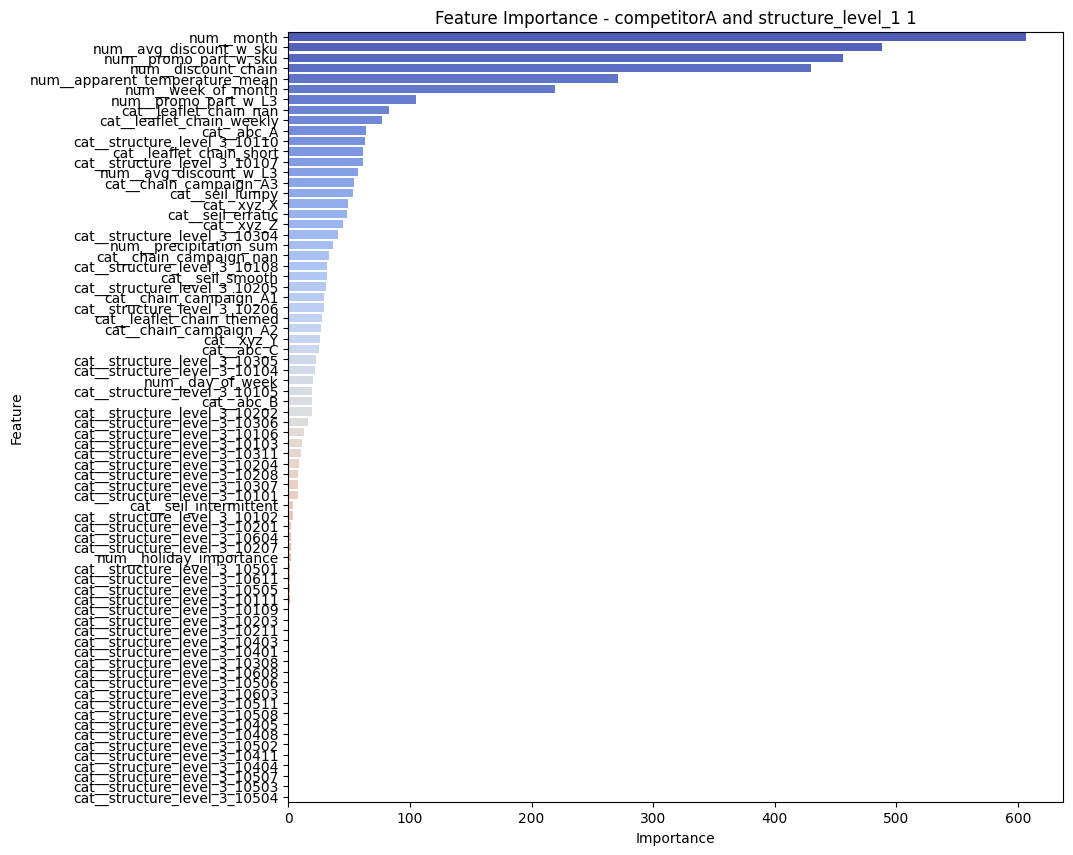

Model  final_model_it_structL1_1_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorB
df2_it:  220328

 Best Parameters for  competitorB  and structure_level_1  1 : 
 {'model__num_leaves': 31, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorB  0.117762  1.537431

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorB  0.159703  2.865947
1               102  competitorB  0.082335  0.271107
2               103  competitorB  0.027878 -0.264715
3               104  competitorB  0.074421 -1.117884
4               105  competitorB  0.048337 -0.717584
5               106  competitorB  0.007214 -0.1692

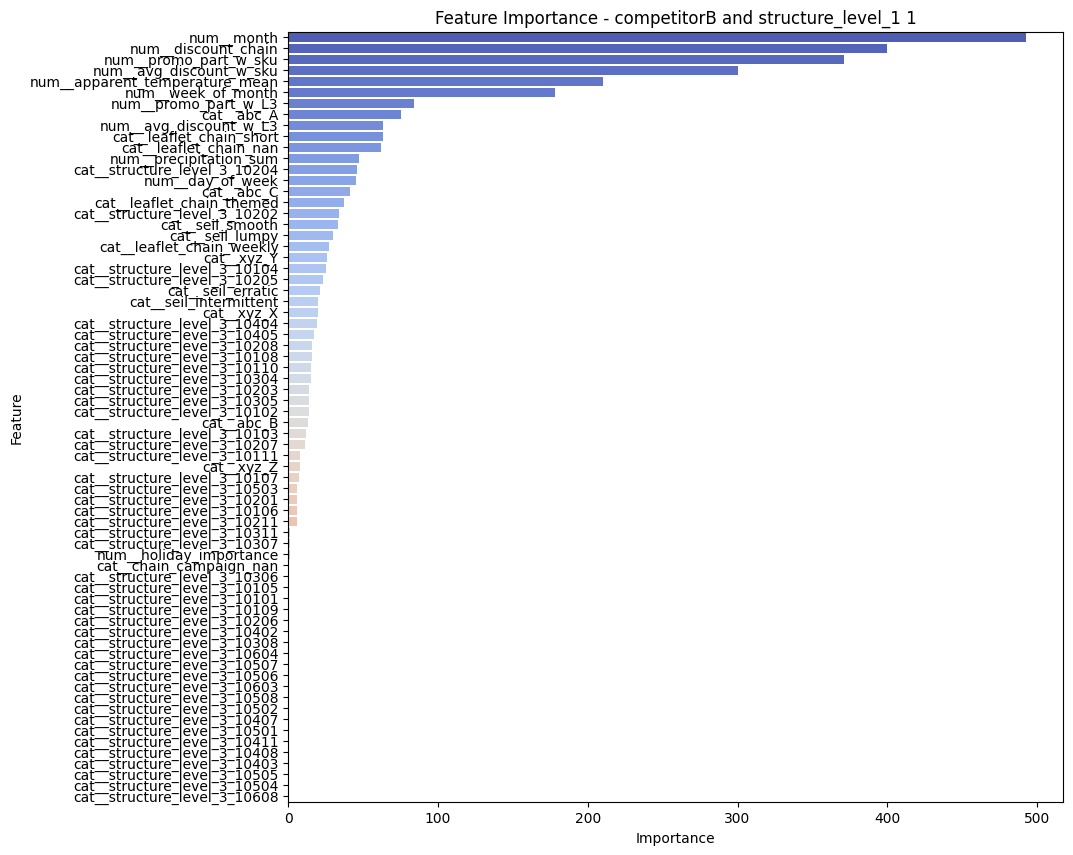

Model  final_model_it_structL1_1_competitorB.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  2
Competitor:  competitorA
df2_it:  311378

 Best Parameters for  competitorA  and structure_level_1  2 : 
 {'model__num_leaves': 40, 'model__n_estimators': 500, 'model__max_depth': 7, 'model__learning_rate': 0.1}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  2 : 
   structure_level_1   competitor      mape      bias
0                 2  competitorA  0.071366  0.882118

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               201  competitorA  0.050651  2.999549
1               202  competitorA  0.090148  0.260158

 Feature Importance:


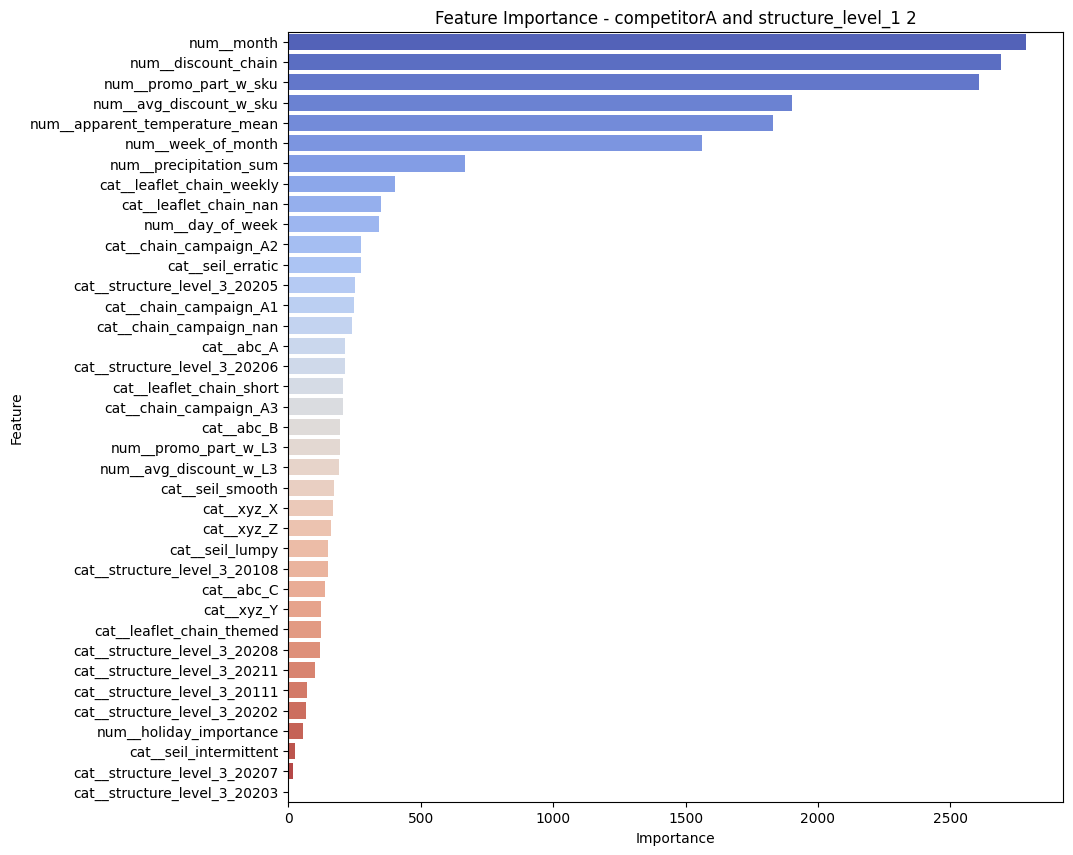

Model  final_model_it_structL1_2_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  2
Competitor:  competitorB
df2_it:  141123

 Best Parameters for  competitorB  and structure_level_1  2 : 
 {'model__num_leaves': 20, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.01}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  2 : 
   structure_level_1   competitor      mape      bias
0                 2  competitorB  0.079996 -1.037668

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               201  competitorB  0.091741 -5.221653
1               202  competitorB  0.066023  0.160611

 Feature Importance:


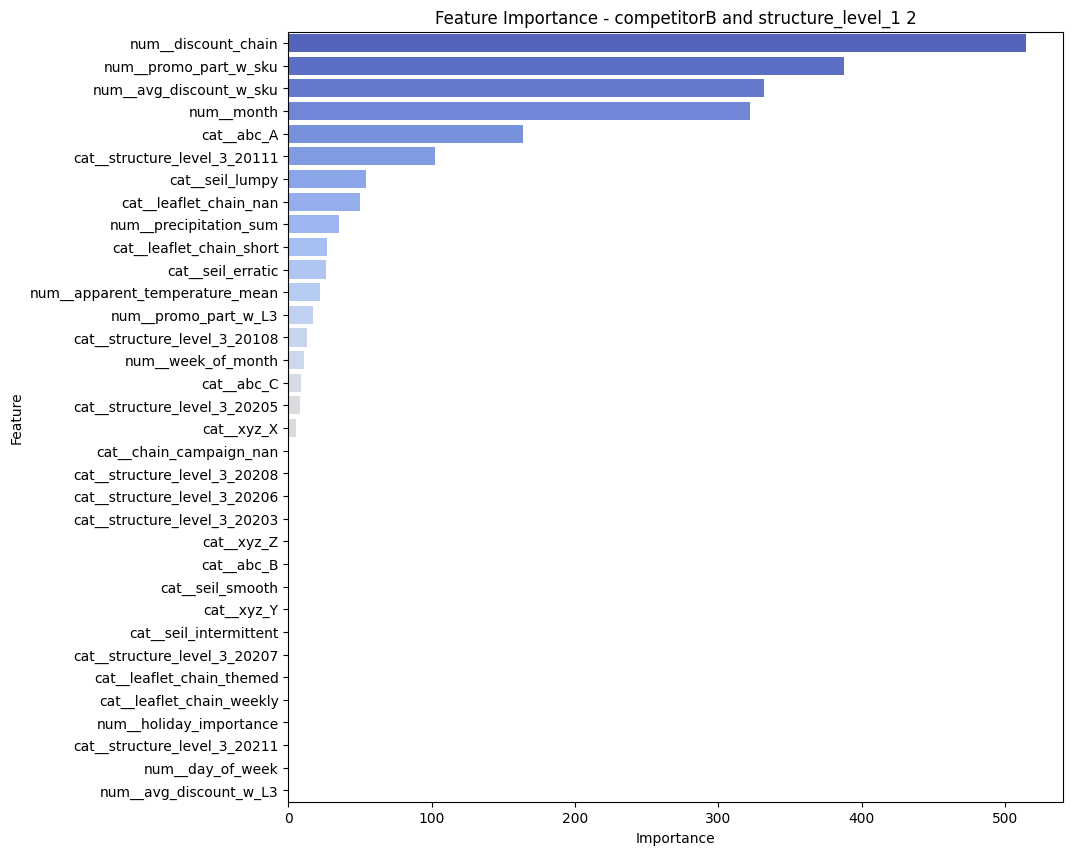

Model  final_model_it_structL1_2_competitorB.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  3
Competitor:  competitorA
df2_it:  962675

 Best Parameters for  competitorA  and structure_level_1  3 : 
 {'model__num_leaves': 40, 'model__n_estimators': 500, 'model__max_depth': 7, 'model__learning_rate': 0.1}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  3 : 
   structure_level_1   competitor      mape      bias
0                 3  competitorA  0.086386  0.351687

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               301  competitorA  0.086022 -0.100924
1               302  competitorA  0.089071  0.123638
2               303  competitorA  0.087447  0.645999
3               304  competitorA  0.108488  0.743560
4               305  competitorA  0.036534  0.511702

 Feature Importance:


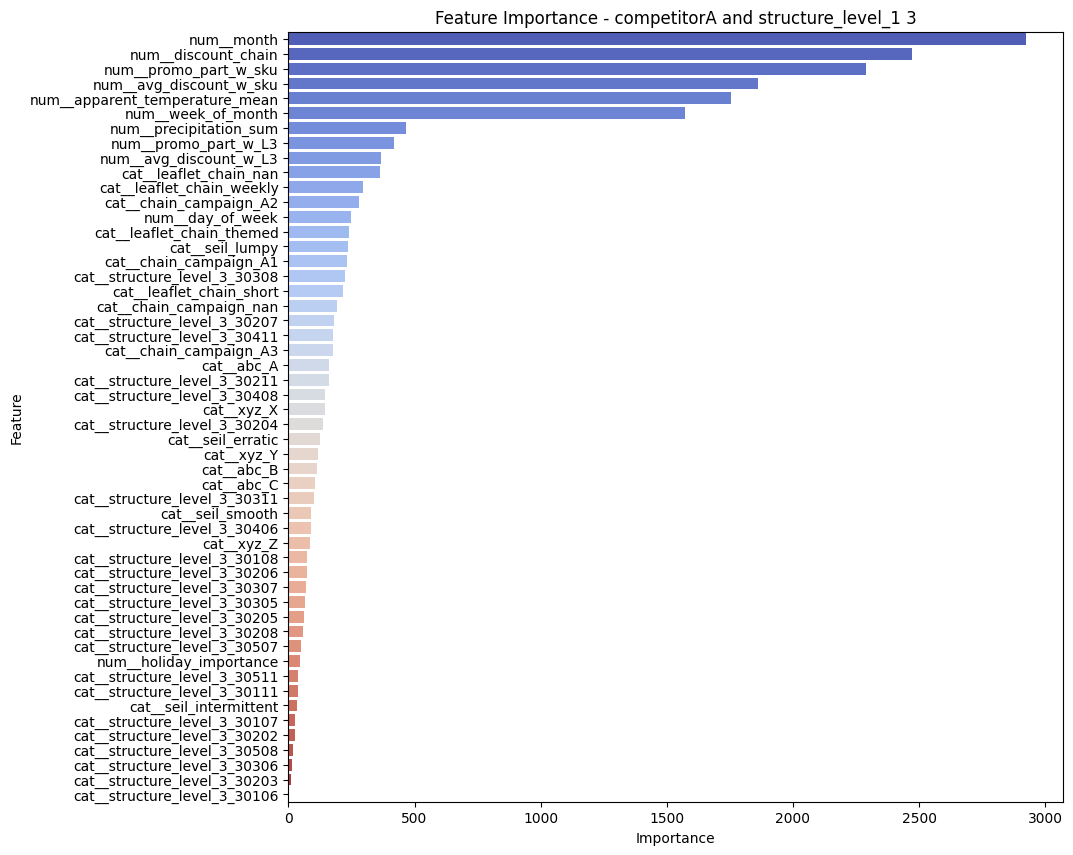

Model  final_model_it_structL1_3_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  3
Competitor:  competitorB
df2_it:  234147

 Best Parameters for  competitorB  and structure_level_1  3 : 
 {'model__num_leaves': 40, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  3 : 
   structure_level_1   competitor      mape      bias
0                 3  competitorB  0.044293  0.462525

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               301  competitorB  0.022111  0.258559
1               302  competitorB  0.050002  0.754595
2               303  competitorB  0.055188  0.456245
3               304  competitorB  0.034419  0.091533
4               305  competitorB  0.008666  0.098759

 Feature Importance:


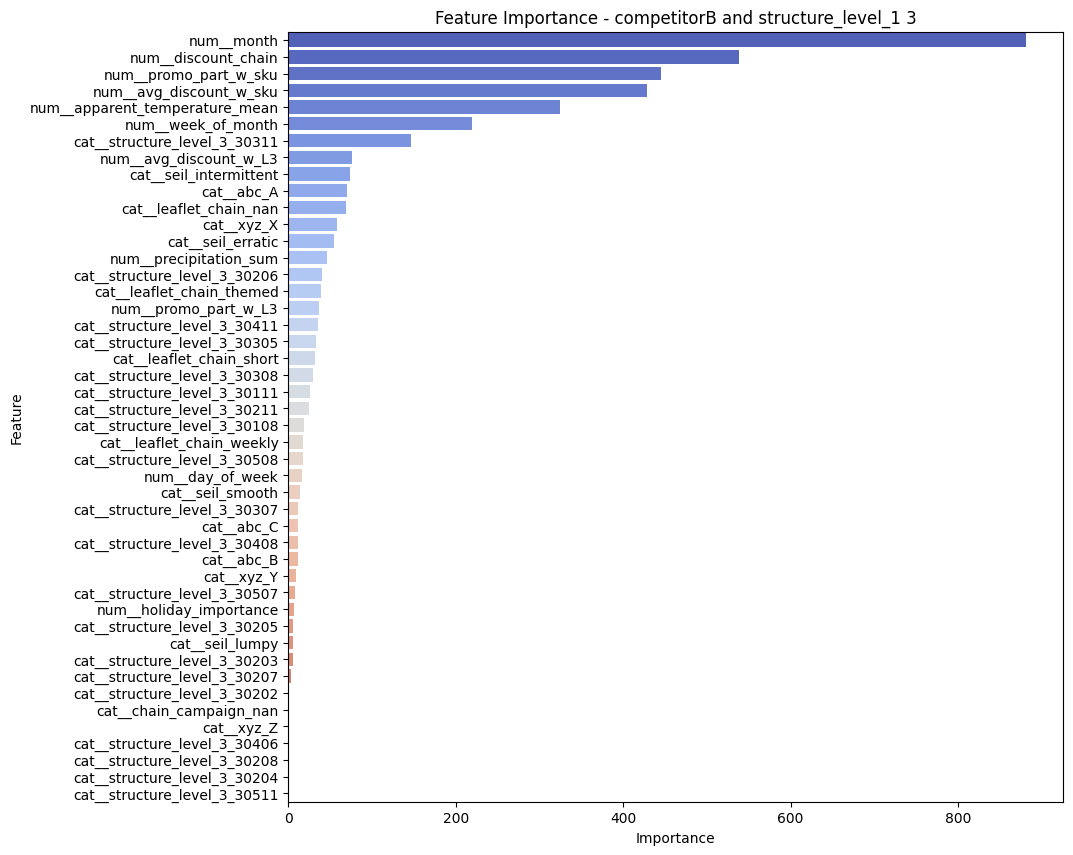

Model  final_model_it_structL1_3_competitorB.pickle  saved in ' models '




In [ ]:
## Train a model for each competitor and structure of level 1
all_predictions_lgbm_discount = []
for struct1 in list_structure_level_1:
    for comp in list_competitor:
        print("***************************************************************************************************")
        print("Structure_level_1: ", struct1)
        print("Competitor: ", comp)

        ## 1. Filter dataset
        df2_it = df2[((df2["competitor"] == comp) & (df2["structure_level_1"]==struct1))].copy()
        df2_it = df2_it.drop('structure_level_1', axis=1)
        print("df2_it: ", len(df2_it))


        ## 2. Define train-test split date (e.g., last 4 months for testing)
        excluded_cols = ["sku", "date", "competitor", "discount", "pvp_was", "quantity"]
        train_cutoff = pd.to_datetime("2024-06-04")  
        df2_it_train = df2_it[df2_it["date"] < train_cutoff]
        X_train_it = df2_it_train.drop(columns=excluded_cols)
        y_train_it = df2_it_train["discount"]
        df2_it_test = df2_it[df2_it["date"] >= train_cutoff]
        X_test_it = df2_it_test.drop(columns=excluded_cols)
        y_test_it = df2_it_test["discount"]

        ## 3. Apply Transformations
        categorical_features = ["chain_campaign", "abc", "seil", "xyz", 'structure_level_3', 'leaflet_chain']
        continuous_features = ["holiday_importance",
                            "apparent_temperature_mean", "precipitation_sum", 
                            "month", "day_of_week", "week_of_month", 'discount_chain', 'avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku']

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                ("num", StandardScaler(), continuous_features)
            ])

        ## 4. Hyperparameter Tunning
        param_grid = {
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [3, 5, 7],
            "model__num_leaves": [20, 31, 40],
        }
        pipeline_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42, verbose=-1))])
        random_search_it = RandomizedSearchCV(pipeline_it, param_grid,n_iter=81, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42, verbose=0)
        # random_search_it = GridSearchCV(pipeline_it, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
        random_search_it.fit(X_train_it, y_train_it)
        best_params_it = random_search_it.best_params_
        print("\n Best Parameters for ", comp, " and structure_level_1 ", struct1, ": \n",  best_params_it)

        ## 5. Evaluate predictions
        df2_it_input = df_input[((df_input["competitor"] == comp) & (df_input["structure_level_1"]==struct1))].copy()
        best_model_it = random_search_it.best_estimator_
        y_pred_it = best_model_it.predict(X_test_it)
        final_preds_it = df2_it_input.loc[X_test_it.index].copy()
        final_preds_it["discount_pred"] = y_pred_it
        
        df_last_pvp_was = df2_it_train.groupby('sku').tail(1).reset_index(drop=True)[['sku', 'pvp_was']].rename(columns={"pvp_was":"last_pvp_was_train"})
        final_preds_it = final_preds_it.merge(df_last_pvp_was,on=['sku'], how='left')
        final_preds_it['pvp_is_pred'] = final_preds_it['last_pvp_was_train']*(1-final_preds_it['discount_pred'])

        df_all_predictions_lgbm_discount = pd.concat(final_preds_it, ignore_index=True)

        result_1 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)
        result_2 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_2", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS by structure level 2:\n", result_2)

        ## 6. Feature Importance
        X_train_transformed_it = best_model_it.named_steps["preprocessor"].transform(X_train_it)
        feature_names_it = best_model_it.named_steps["preprocessor"].get_feature_names_out()
        print("\n Feature Importance:")
        plot_feature_importance(best_model_it, feature_names_it, "Feature Importance - " + comp + " and structure_level_1 " + struct1)


        # 7. Retrain model on full dataset
        clean_params_it = {key.replace("model__", ""): value for key, value in best_params_it.items()}
        final_model_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(**clean_params_it))])
        X_it = df2_it.drop(columns=excluded_cols)
        y_it = df2_it["discount"]
        final_model_it.fit(X_it, y_it)
        
        ## 8. Save Model
        TMP_DIR = 'models'
        joblib.dump(final_model_it, os.path.join(TMP_DIR, f'final_model_it_structL1_{struct1}_{comp}.pickle'))
        print("Model ", f'final_model_it_structL1_{struct1}_{comp}.pickle',  " saved in '", TMP_DIR, "'\n\n")


In [ ]:
final_preds_it.loc[final_preds_it.sku==3578].drop(['structure_level_4','structure_level_3','structure_level_2','structure_level_1'], axis=1)[['discount_pred', 'date']].groupby('discount_pred').count()

In [46]:
final_preds_it.loc[final_preds_it.sku==3578].drop(['structure_level_4','structure_level_3','structure_level_2','structure_level_1'], axis=1)[['discount_pred', 'date']].groupby('discount_pred').count()

,date
discount_pred,
0.013075,140
0.020702,7


In [48]:
final_preds_it.loc[final_preds_it.sku==3578].drop(['structure_level_4','structure_level_3','structure_level_2','structure_level_1'], axis=1).discount_pred.unique()

array([0.01307488, 0.02070241])

In [49]:
final_preds_it.loc[final_preds_it.sku==3578].drop(['structure_level_4','structure_level_3','structure_level_2','structure_level_1'], axis=1)[['discount', 'date']].groupby('discount').count()

,date
discount,
0.0000,108
0.1950,11
0.2061,3
0.2228,6
0.2507,16
0.2618,3


#### test 

In [59]:
list_structure_level_1=df_input['structure_level_1'].sort_values().unique()
list_competitor=df_input['competitor'].sort_values().unique()

In [60]:
list_structure_level_1=['1']

In [61]:
df2 = df_input[['sku', 'date','competitor', ## keys
                'discount', ## target 
                'pvp_was',
                'quantity', ## used for evaluation
                ## features:
                'structure_level_3', 'structure_level_1', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
                'chain_campaign', 'holiday_importance','avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
                'month', 'day_of_week', 'week_of_month',
                'apparent_temperature_mean', 'precipitation_sum', 
                'abc', 'seil', 'xyz',
                'discount_chain', 'leaflet_chain']]

#  'pvp_was' 'discount', 'flag_promo', 'leaflet'  flg_filled_gap 'pvp_is_lag_1', 'pvp_is_lag_7', 'pvp_is_lag_30', 'rolling_mean_7' 'rolling_mean_30' holiday

***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorA
df2_it:  346095

 Best Parameters for  competitorA  and structure_level_1  1 : 
 {'model__num_leaves': 40, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.135849  1.917332

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorA  0.200933  3.311219
1               102  competitorA  0.070216  0.422795
2               103  competitorA  0.021261 -0.023280
3               104  competitorA  0.084368  0.156588
4               105  competitorA  0.006488 -0.198308
5               106  competitorA  0.016919  0.249348

 Feature Importance:


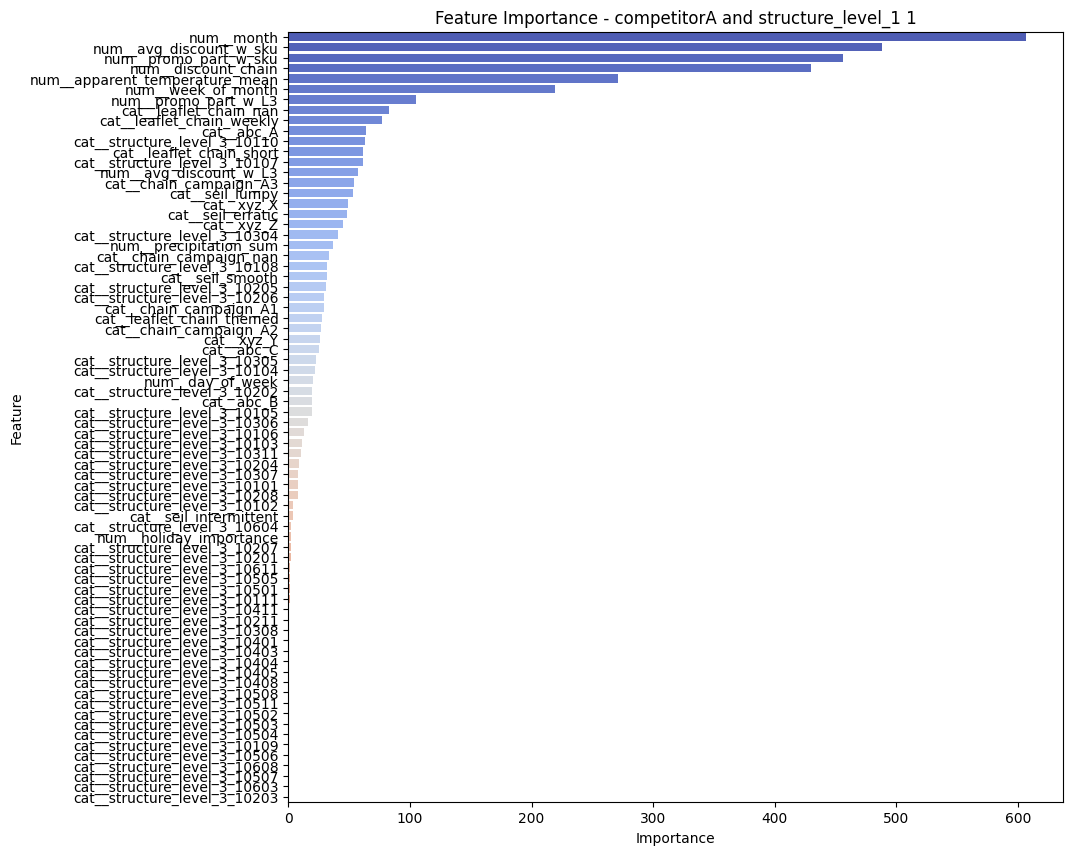

Model  final_model_it_structL1_1_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorB
df2_it:  220328

 Best Parameters for  competitorB  and structure_level_1  1 : 
 {'model__num_leaves': 31, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorB  0.117762  1.537431

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorB  0.159703  2.865947
1               102  competitorB  0.082335  0.271107
2               103  competitorB  0.027878 -0.264715
3               104  competitorB  0.074421 -1.117884
4               105  competitorB  0.048337 -0.717584
5               106  competitorB  0.007214 -0.1692

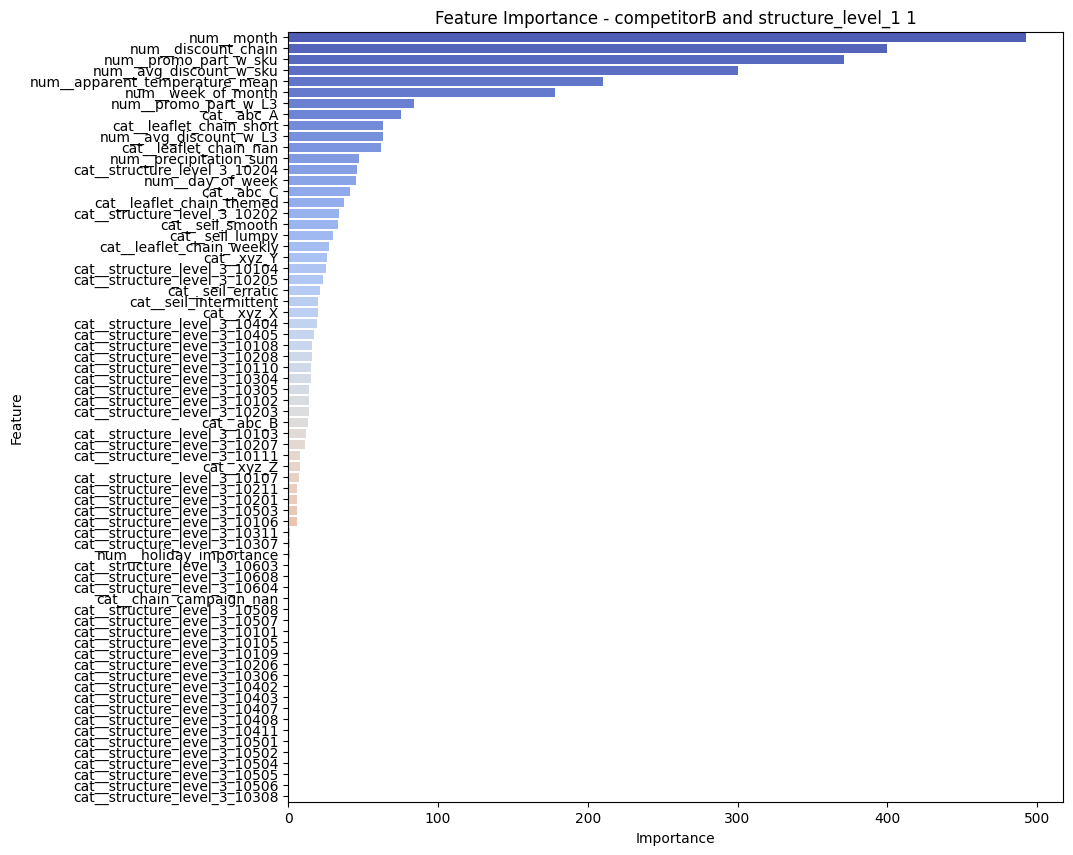

Model  final_model_it_structL1_1_competitorB.pickle  saved in ' models '




In [62]:
## Train a model for each competitor and structure of level 1
all_predictions_lgbm_discount = []
for struct1 in list_structure_level_1:
    for comp in list_competitor:
        print("***************************************************************************************************")
        print("Structure_level_1: ", struct1)
        print("Competitor: ", comp)

        ## 1. Filter dataset
        df2_it = df2[((df2["competitor"] == comp) & (df2["structure_level_1"]==struct1))].copy()
        df2_it = df2_it.drop('structure_level_1', axis=1)
        print("df2_it: ", len(df2_it))


        ## 2. Define train-test split date (e.g., last 4 months for testing)
        excluded_cols = ["sku", "date", "competitor", "discount", "pvp_was", "quantity"]
        train_cutoff = pd.to_datetime("2024-06-04")  
        df2_it_train = df2_it[df2_it["date"] < train_cutoff]
        X_train_it = df2_it_train.drop(columns=excluded_cols)
        y_train_it = df2_it_train["discount"]
        df2_it_test = df2_it[df2_it["date"] >= train_cutoff]
        X_test_it = df2_it_test.drop(columns=excluded_cols)
        y_test_it = df2_it_test["discount"]

        ## 3. Apply Transformations
        categorical_features = ["chain_campaign", "abc", "seil", "xyz", 'structure_level_3', 'leaflet_chain']
        continuous_features = ["holiday_importance",
                            "apparent_temperature_mean", "precipitation_sum", 
                            "month", "day_of_week", "week_of_month", 'discount_chain', 'avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku']

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                ("num", StandardScaler(), continuous_features)
            ])

        ## 4. Hyperparameter Tunning
        param_grid = {
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [3, 5, 7],
            "model__num_leaves": [20, 31, 40],
        }
        pipeline_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42, verbose=-1))])
        random_search_it = RandomizedSearchCV(pipeline_it, param_grid,n_iter=81, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42, verbose=0)
        # random_search_it = GridSearchCV(pipeline_it, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
        random_search_it.fit(X_train_it, y_train_it)
        best_params_it = random_search_it.best_params_
        print("\n Best Parameters for ", comp, " and structure_level_1 ", struct1, ": \n",  best_params_it)

        ## 5. Evaluate predictions
        df2_it_input = df_input[((df_input["competitor"] == comp) & (df_input["structure_level_1"]==struct1))].copy()
        best_model_it = random_search_it.best_estimator_
        y_pred_it = best_model_it.predict(X_test_it)
        final_preds_it = df2_it_input.loc[X_test_it.index].copy()
        final_preds_it["discount_pred"] = y_pred_it
        
        df_last_pvp_was = df2_it_train.groupby('sku').tail(1).reset_index(drop=True)[['sku', 'pvp_was']].rename(columns={"pvp_was":"last_pvp_was_train"})
        final_preds_it = final_preds_it.merge(df_last_pvp_was,on=['sku'], how='left')
        final_preds_it['pvp_is_pred'] = final_preds_it['last_pvp_was_train']*(1-final_preds_it['discount_pred'])

        all_predictions_lgbm_discount.append(final_preds_it)

        result_1 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)
        result_2 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_2", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS by structure level 2:\n", result_2)

        ## 6. Feature Importance
        X_train_transformed_it = best_model_it.named_steps["preprocessor"].transform(X_train_it)
        feature_names_it = best_model_it.named_steps["preprocessor"].get_feature_names_out()
        print("\n Feature Importance:")
        plot_feature_importance(best_model_it, feature_names_it, "Feature Importance - " + comp + " and structure_level_1 " + struct1)


        # 7. Retrain model on full dataset
        clean_params_it = {key.replace("model__", ""): value for key, value in best_params_it.items()}
        final_model_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(**clean_params_it))])
        X_it = df2_it.drop(columns=excluded_cols)
        y_it = df2_it["discount"]
        final_model_it.fit(X_it, y_it)
        
        ## 8. Save Model
        TMP_DIR = 'models'
        joblib.dump(final_model_it, os.path.join(TMP_DIR, f'final_model_it_structL1_{struct1}_{comp}.pickle'))
        print("Model ", f'final_model_it_structL1_{struct1}_{comp}.pickle',  " saved in '", TMP_DIR, "'\n\n")

df_all_predictions_lgbm_discount = pd.concat(all_predictions_lgbm_discount, ignore_index=True)


In [63]:
df_all_predictions_lgbm_discount.to_csv("20250512_12:30_lgbm_discount_structL1_1.csv")

In [64]:
df_comp_with_arima = df_all_predictions_lgbm_discount.loc[df_all_predictions_lgbm_discount.sku.isin([2794,2821,2735,2734,2786,2754,2729,2728,2664,2992,2600,2993,2736,2733,2732,2822,2781,2671,2863,
                    2699,2731,2893,2674,2894,2712,2669,2667,2666,2672,2895,2673,2737,2779,2881,2661,2659,2624,2646,
                    2662,2658,2663,2626,2628,2941,2625,2939,2940,2942,2630,2623,2965,2620,2601,2581,2605,2602,2603])]

In [65]:
result_1 = grouped_weighted_mape_bias(df_comp_with_arima, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)


 Weighted MAPE & BIAS for  competitorB  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.034916 -0.116522
1                 1  competitorB  0.040965 -0.242757


#### test2 (sem spoiler)

In [84]:
list_structure_level_1=df_input['structure_level_1'].sort_values().unique()
list_competitor=df_input['competitor'].sort_values().unique()

In [98]:
list_structure_level_1=['2','3']

In [99]:
df2 = df_input[['sku', 'date','competitor', ## keys
                'discount', ## target 
                'pvp_was',
                'quantity', ## used for evaluation
                ## features:
                'structure_level_3', 'structure_level_1', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
                'holiday_importance','avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
                'pvp_is_lag_7', 'discount_lag_7', 'days_since_last_promo',
                'month', 'day_of_week', 'week_of_month',
                'apparent_temperature_mean', 'precipitation_sum', 
                'abc', 'seil', 'xyz']]

#  'pvp_was' 'discount', 'flag_promo', 'leaflet'  flg_filled_gap 'pvp_is_lag_1', 'pvp_is_lag_7', 'pvp_is_lag_30', 'rolling_mean_7' 'rolling_mean_30' holiday

***************************************************************************************************
Structure_level_1:  2
Competitor:  competitorA
df2_it:  311378

 Best Parameters for  competitorA  and structure_level_1  2 : 
 {'model__num_leaves': 20, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  2 : 
   structure_level_1   competitor      mape      bias
0                 2  competitorA  0.020967 -0.043132

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               201  competitorA  0.010359 -0.257392
1               202  competitorA  0.030584  0.019803

Feature Importance - competitorA and structure_level_1: 
                           Feature  Importance (%)
27         num__avg_discount_w_sku       24.210526
30             num__discount_lag_7       24.000000
29               num__pvp_is_lag_7       15.210526
22                    

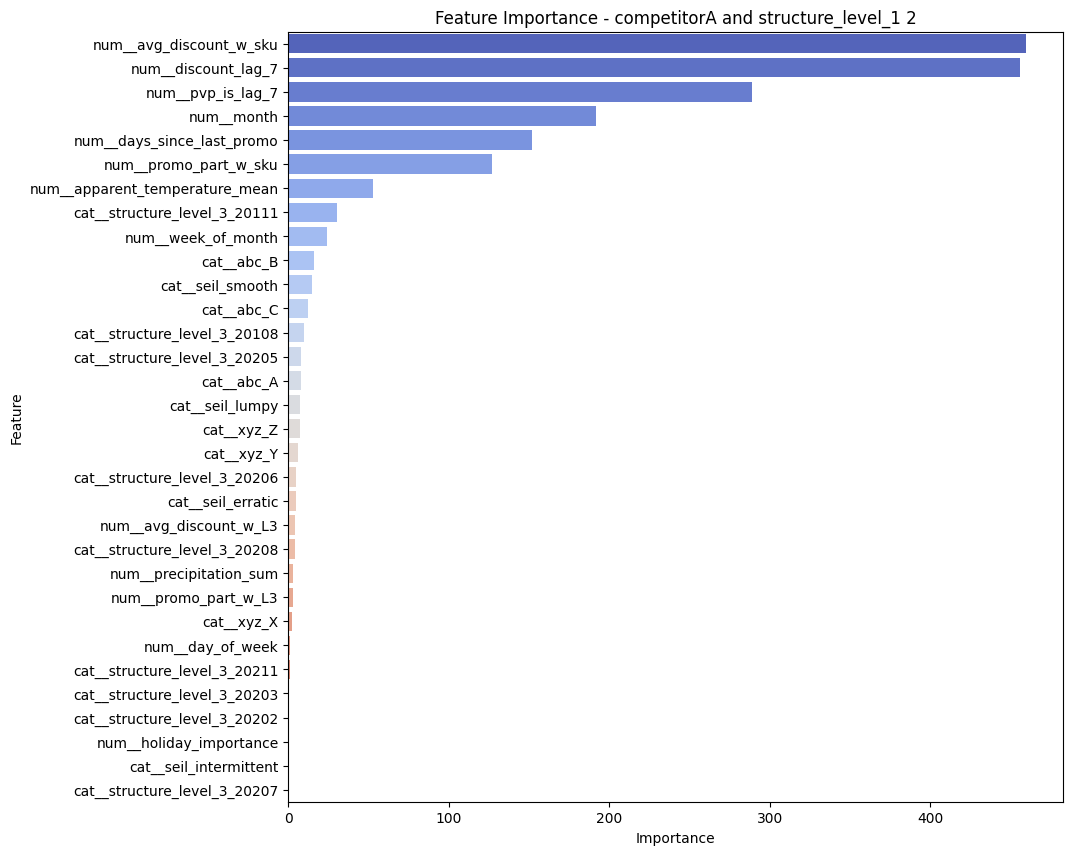

Model  final_model_it_structL1_2_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  2
Competitor:  competitorB
df2_it:  141123

 Best Parameters for  competitorB  and structure_level_1  2 : 
 {'model__num_leaves': 20, 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.01}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  2 : 
   structure_level_1   competitor      mape      bias
0                 2  competitorB  0.074896 -1.924964

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               201  competitorB  0.100806 -8.004083
1               202  competitorB  0.044071 -0.183925

Feature Importance - competitorB and structure_level_1: 
                           Feature  Importance (%)
29             num__discount_lag_7       43.702844
26         num__avg_discount_w_sku       24.34706

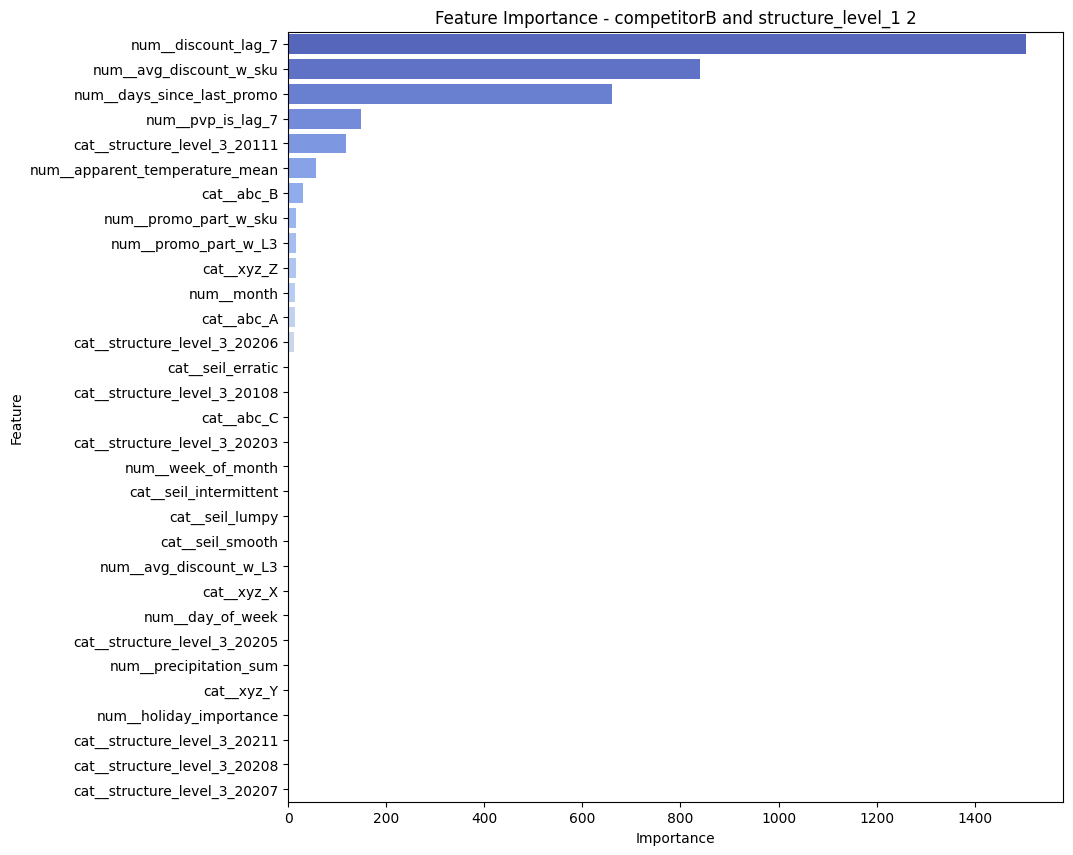

Model  final_model_it_structL1_2_competitorB.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  3
Competitor:  competitorA
df2_it:  962675

 Best Parameters for  competitorA  and structure_level_1  3 : 
 {'model__num_leaves': 40, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.1}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  3 : 
   structure_level_1   competitor      mape      bias
0                 3  competitorA  0.016342  0.032711

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               301  competitorA  0.024692 -0.417901
1               302  competitorA  0.010040  0.019247
2               303  competitorA  0.016639  0.232016
3               304  competitorA  0.017964  0.238138
4               305  competitorA  0.004747  0.021276

Feature Importance - competitorA and structure_lev

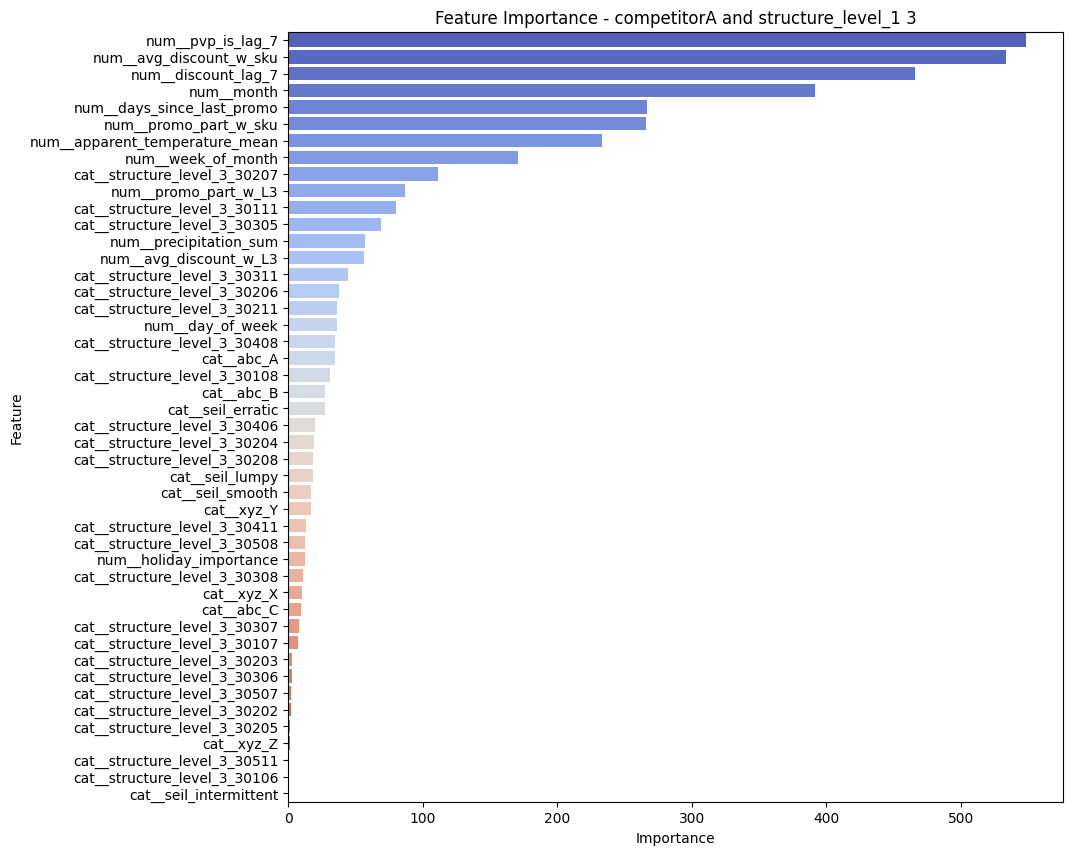

Model  final_model_it_structL1_3_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  3
Competitor:  competitorB
df2_it:  234147

 Best Parameters for  competitorB  and structure_level_1  3 : 
 {'model__num_leaves': 20, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  3 : 
   structure_level_1   competitor      mape      bias
0                 3  competitorB  0.021366  0.286792

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               301  competitorB  0.009263  0.227823
1               302  competitorB  0.026238  0.328101
2               303  competitorB  0.025840  0.320303
3               304  competitorB  0.026568 -0.069088
4               305  competitorB  0.005909  0.211967

Feature Importance - competitorB and structure_lev

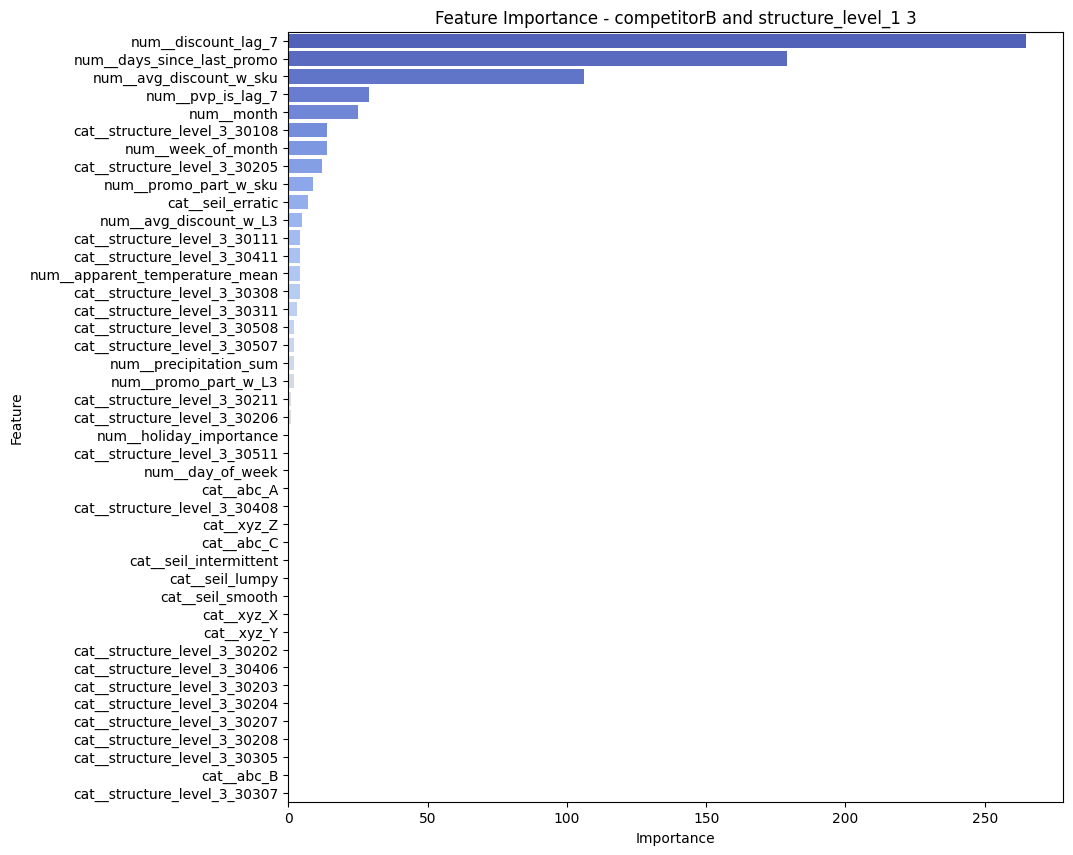

Model  final_model_it_structL1_3_competitorB.pickle  saved in ' models '




In [100]:
## Train a model for each competitor and structure of level 1
all_predictions_lgbm_discount = []
for struct1 in list_structure_level_1:
    for comp in list_competitor:
        print("***************************************************************************************************")
        print("Structure_level_1: ", struct1)
        print("Competitor: ", comp)

        ## 1. Filter dataset
        df2_it = df2[((df2["competitor"] == comp) & (df2["structure_level_1"]==struct1))].copy()
        df2_it = df2_it.drop('structure_level_1', axis=1)
        print("df2_it: ", len(df2_it))


        ## 2. Define train-test split date (e.g., last 4 months for testing)
        excluded_cols = ["sku", "date", "competitor", "discount", "pvp_was", "quantity"]
        train_cutoff = pd.to_datetime("2024-06-04")  
        df2_it_train = df2_it[df2_it["date"] < train_cutoff]
        X_train_it = df2_it_train.drop(columns=excluded_cols)
        y_train_it = df2_it_train["discount"]
        df2_it_test = df2_it[df2_it["date"] >= train_cutoff]
        X_test_it = df2_it_test.drop(columns=excluded_cols)
        y_test_it = df2_it_test["discount"]

        ## 3. Apply Transformations
        categorical_features = ["abc", "seil", "xyz", 'structure_level_3']
        continuous_features = ["holiday_importance",
                            "apparent_temperature_mean", "precipitation_sum", 
                            "month", "day_of_week", "week_of_month", 'avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
                            'pvp_is_lag_7', 'discount_lag_7', 'days_since_last_promo']

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                ("num", StandardScaler(), continuous_features)
            ])

        ## 4. Hyperparameter Tunning
        param_grid = {
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [3, 5, 7],
            "model__num_leaves": [20, 31, 40],
        }
        # param_grid = {
        #     "model__learning_rate": [0.01, 0.05],
        #     "model__n_estimators": [100, 300],
        #     "model__max_depth": [3, 5, 7],
        #     "model__num_leaves": [20, 31, 40],
        #     "model__min_child_samples": [10, 20, 30],
        #     "model__subsample": [0.7, 0.9],
        #     "model__colsample_bytree": [0.7, 0.9],
        # }
        pipeline_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42, verbose=-1))])
        random_search_it = RandomizedSearchCV(pipeline_it, param_grid,n_iter=81, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42, verbose=0)
        # random_search_it = GridSearchCV(pipeline_it, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
        random_search_it.fit(X_train_it, y_train_it)
        best_params_it = random_search_it.best_params_
        print("\n Best Parameters for ", comp, " and structure_level_1 ", struct1, ": \n",  best_params_it)

        ## 5. Evaluate predictions
        df2_it_input = df_input[((df_input["competitor"] == comp) & (df_input["structure_level_1"]==struct1))].copy()
        best_model_it = random_search_it.best_estimator_
        y_pred_it = best_model_it.predict(X_test_it)
        final_preds_it = df2_it_input.loc[X_test_it.index].copy()
        final_preds_it["discount_pred"] = y_pred_it
        
        df_last_pvp_was = df2_it_train.groupby('sku').tail(1).reset_index(drop=True)[['sku', 'pvp_was']].rename(columns={"pvp_was":"last_pvp_was_train"})
        final_preds_it = final_preds_it.merge(df_last_pvp_was,on=['sku'], how='left')
        final_preds_it['pvp_is_pred'] = final_preds_it['last_pvp_was_train']*(1-final_preds_it['discount_pred'])

        all_predictions_lgbm_discount.append(final_preds_it)

        result_1 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)
        result_2 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_2", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS by structure level 2:\n", result_2)

        ## 6. Feature Importance
        X_train_transformed_it = best_model_it.named_steps["preprocessor"].transform(X_train_it)
        feature_names_it = best_model_it.named_steps["preprocessor"].get_feature_names_out()

        importance_values = best_model_it.named_steps["model"].feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": feature_names_it,
            "Importance (%)": (importance_values / importance_values.sum()) * 100  # Normalize to %
        })
        feature_importance_df = feature_importance_df.sort_values(by="Importance (%)", ascending=False)
        print("\nFeature Importance - " + comp + " and structure_level_1: ")
        feature_importance_df.to_csv(f"feature_imp/feature_importance_structL1_{struct1}_{comp}.csv")

        print(feature_importance_df)
        plot_feature_importance(best_model_it, feature_names_it, "Feature Importance - " + comp + " and structure_level_1 " + struct1)


        # 7. Retrain model on full dataset
        clean_params_it = {key.replace("model__", ""): value for key, value in best_params_it.items()}
        final_model_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(**clean_params_it))])
        X_it = df2_it.drop(columns=excluded_cols)
        y_it = df2_it["discount"]
        final_model_it.fit(X_it, y_it)
        
        ## 8. Save Model
        TMP_DIR = 'models'
        joblib.dump(final_model_it, os.path.join(TMP_DIR, f'final_model_it_structL1_{struct1}_{comp}.pickle'))
        print("Model ", f'final_model_it_structL1_{struct1}_{comp}.pickle',  " saved in '", TMP_DIR, "'\n\n")

df_all_predictions_lgbm_discount = pd.concat(all_predictions_lgbm_discount, ignore_index=True)


In [101]:
df_all_predictions_lgbm_discount.to_csv("20250512_df_all_predictions_lgbm_discount_STRUCTL1_2_3.csv")

In [102]:
df_comp_with_arima = df_all_predictions_lgbm_discount.loc[df_all_predictions_lgbm_discount.sku.isin([2794,2821,2735,2734,2786,2754,2729,2728,2664,2992,2600,2993,2736,2733,2732,2822,2781,2671,2863,
                    2699,2731,2893,2674,2894,2712,2669,2667,2666,2672,2895,2673,2737,2779,2881,2661,2659,2624,2646,
                    2662,2658,2663,2626,2628,2941,2625,2939,2940,2942,2630,2623,2965,2620,2601,2581,2605,2602,2603])]

In [97]:
result_1 = grouped_weighted_mape_bias(df_comp_with_arima, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)


 Weighted MAPE & BIAS for  competitorA  and structure_level_1  2 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.020613  0.103959
1                 1  competitorB  0.029337 -0.160072


### ARIMA / SARIMA

In [7]:
list_structure_level_1=df_input['structure_level_1'].sort_values().unique()
list_competitor=df_input['competitor'].sort_values().unique()

In [49]:
list_structure_level_1 = ['1']
list_competitor = ['competitorB']

In [50]:
df = df_input[['sku', 'date','competitor', ## keys
                'pvp_is', ## target 
                'quantity', ## used for evaluation
                ## features:
                'structure_level_3', 'structure_level_1', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
                'chain_campaign', 'holiday_importance','avg_discount_w_L3','promo_part_w_L3',
                'month', 'day_of_week', 'week_of_month',
                'apparent_temperature_mean', 'precipitation_sum', 
                'abc', 'seil', 'xyz',
                'discount_chain', 'leaflet_chain']]

In [52]:
# Ensure the models directory exists
TMP_DIR = "models_sarima"
os.makedirs(TMP_DIR, exist_ok=True)

# Ensure date is in datetime format
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
train_cutoff = pd.to_datetime("2024-06-04")

results = []
all_predictions = []

# Loop through structure_level_1 & competitors
for struct1 in list_structure_level_1:
    for comp in list_competitor:
        print("***************************************************************************************************")
        print(f"Structure_level_1: {struct1}, Competitor: {comp}")

        ## 1️. Filter dataset
        df_filtered = df[(df['structure_level_1'] == struct1) & (df['competitor'] == comp)].copy()

        # for sku in df_filtered['sku'].unique():
        for sku in [2794,2821,2735,2734,2786,2754,2729,2728,2664,2992,2600,2993,2736,2733,2732,2822,2781,2671,2863,
                    2699,2731,2893,2674,2894,2712,2669,2667,2666,2672,2895,2673,2737,2779,2881,2661,2659,2624,2646,
                    2662,2658,2663,2626,2628,2941,2625,2939,2940,2942,2630,2623,2965,2620,2601,2581,2605,2602,2603]:
            df_sku = df_filtered[df_filtered['sku'] == sku].sort_values('date')

            if len(df_sku) < 30:
                print("sku ", sku, " and ", comp, " too short <30: ", len(df_sku))
                continue  # skip too short series

            df_sku = df_sku[['date', 'pvp_is', 'quantity']].dropna().drop_duplicates()
            df_sku['date'] = pd.to_datetime(df_sku['date'])
            df_sku = df_sku.set_index('date')
            df_sku = df_sku.asfreq('D')
            df_sku = df_sku.ffill() ## there should be no nan at this step -> just doing to prevent

            # Train-test split
            df_train = df_sku[df_sku.index < train_cutoff].dropna()
            df_test = df_sku[df_sku.index >= train_cutoff].dropna()

            if len(df_test) == 0 or len(df_train) < 14:
                print("sku ", sku, " and ", comp, " too short len(df_test)==0: ", len(df_test), " or len(df_train)<14: ",len(df_train))
                continue
            try:
                # Fit auto-SARIMA model
                model = auto_arima(
                    df_train['pvp_is'],
                    start_p=1, start_q=1, max_p=3, max_q=3,
                    d=None,           # Let it infer if differencing is needed
                    seasonal=True,
                    m=7,              # Weekly pattern
                    start_P=0, start_Q=0, max_P=2, max_Q=2,
                    D=1,
                    suppress_warnings=True,
                    stepwise=True
                )

                forecast = model.predict(n_periods=len(df_test))
                if np.all(np.isnan(forecast)):
                    print(f"Forecast returned all NaNs for SKU {sku}")
                    continue

                # Evaluate
                df_test = df_test.copy()
                df_test['pvp_is_pred'] = forecast
                df_test['sku'] = sku
                df_test['competitor'] = comp
                df_test['structure_level_1'] = struct1
                df_test = df_test.reset_index().rename(columns={'index': 'date'})

                all_predictions.append(df_test)

                df_test['abs_error'] = np.abs(df_test['pvp_is_pred'] - df_test['pvp_is'])
                df_test['error'] = df_test['pvp_is_pred'] - df_test['pvp_is']

                # Use quantity for weighting
                df_test['weight'] = df_test['quantity'].fillna(0)

                total_weight = df_test['weight'].sum()
                if total_weight == 0:
                    mape = np.nan
                    bias = np.nan
                else:
                    mape = (df_test['abs_error'] / df_test['pvp_is'] * df_test['weight']).sum() / total_weight
                    bias = (df_test['error'] * df_test['weight']).sum() / total_weight

                results.append({
                    'structure_level_1': struct1,
                    'competitor': comp,
                    'sku': sku,
                    'mape': mape,
                    'bias': bias,
                    'model_params': model.get_params()
                })

                # Retrain on full data
                model.fit(df_sku['pvp_is'])
                model_path = os.path.join(TMP_DIR, f"sarima_struct{struct1}_{comp}_sku{sku}.pkl")
                joblib.dump(model, model_path)

            except Exception as e:
                print(f" Failed for SKU {sku}: {e}")
                continue
        
        if len(results)>0:
            # Combine and summarize results
            df_predictions = pd.concat(all_predictions, ignore_index=True)
            df_sarima_results = pd.DataFrame(results)
            
    print("\n=== Summary by Structure & Competitor ===")
    print(grouped_weighted_mape_bias(df_predictions, ['structure_level_1', 'competitor'], 'pvp_is', 'pvp_is_pred', 'quantity'))

    print("\n Models and predictions saved.")

        #  ## 2️. Define train-test split date
        
        # train_series = df_it["pvp_is"][df_it.index < train_cutoff]
        # test_series = df_it["pvp_is"][df_it.index >= train_cutoff]
        
        # ## 3️. Fit ARIMA Model
        # arima_model = ARIMA(train_series, order=(2,1,2))  # (p,d,q) parameters can be tuned
        # arima_result = arima_model.fit()

        # # ## 4️. Fit SARIMA Model (if seasonality exists)
        # # sarima_model = SARIMAX(train_series, order=(2,1,2), seasonal_order=(1,1,1,12))  # Monthly seasonality
        # # sarima_result = sarima_model.fit()

        # ## 5️. Forecast on Test Data
        # arima_forecast = arima_result.forecast(steps=len(test_series))
        # # sarima_forecast = sarima_result.forecast(steps=len(test_series))

        # ## 6️. Save Models
        # joblib.dump(arima_result, os.path.join(TMP_DIR, f'arima_model_structL1_{struct1}_{comp}.pickle'))
        # # joblib.dump(sarima_result, os.path.join(TMP_DIR, f'sarima_model_structL1_{struct1}_{comp}.pickle'))
        # print(f"Models saved for Structure Level 1: {struct1}, Competitor: {comp}")

        # ## 7️. Evaluate Models (MAPE & Bias)
        # mape_arima = mean_absolute_percentage_error(test_series, arima_forecast)
        # # mape_sarima = mean_absolute_percentage_error(test_series, sarima_forecast)

        # bias_arima = (arima_forecast - test_series).sum() / test_series.sum()
        # # bias_sarima = (sarima_forecast - test_series).sum() / test_series.sum()

        # print(f"\n Evaluation for Competitor {comp}:")
        # print(f"MAPE for ARIMA: {mape_arima:.4f}")
        # print(f"Bias for ARIMA: {bias_arima:.4f}")
        # # print(f"MAPE for SARIMA: {mape_sarima:.4f}")
        # # print(f"Bias for SARIMA: {bias_sarima:.4f}")


C:\Users\catar\AppData\Local\Temp\ipykernel_18420\2830822718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


***************************************************************************************************
Structure_level_1: 1, Competitor: competitorB
sku  2821  and  competitorB  too short <30:  0
sku  2734  and  competitorB  too short <30:  0
sku  2786  and  competitorB  too short <30:  0
sku  2754  and  competitorB  too short <30:  0
sku  2664  and  competitorB  too short <30:  0
sku  2992  and  competitorB  too short <30:  0
sku  2993  and  competitorB  too short <30:  0
sku  2822  and  competitorB  too short <30:  0
sku  2699  and  competitorB  too short <30:  0


c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(2,1,0)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "c:\Users\catar\AppData\Local\Pro

sku  2712  and  competitorB  too short <30:  0
sku  2669  and  competitorB  too short <30:  0


c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


sku  2672  and  competitorB  too short <30:  0
sku  2673  and  competitorB  too short <30:  0
sku  2779  and  competitorB  too short <30:  0
sku  2881  and  competitorB  too short <30:  0


c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,2)(2,1,0)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\catar\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "c:\Users\catar\AppData\Local\Pro

sku  2628  and  competitorB  too short <30:  0
sku  2941  and  competitorB  too short <30:  0
sku  2939  and  competitorB  too short <30:  0
sku  2940  and  competitorB  too short <30:  0
sku  2942  and  competitorB  too short <30:  0
sku  2623  and  competitorB  too short <30:  0
sku  2620  and  competitorB  too short <30:  0
sku  2605  and  competitorB  too short <30:  0
sku  2602  and  competitorB  too short <30:  0

=== Summary by Structure & Competitor ===
  structure_level_1   competitor      mape     bias
0                 1  competitorB  0.060523 -1.20181

 Models and predictions saved.


In [53]:
# df_predictions.to_csv("20250512_df_predictions_auto_arima_57_skus_compA_structL1_1.csv")
df_predictions.to_csv("20250512_df_predictions_auto_arima_57_skus_compB_structL1_1.csv")

In [36]:
if len(results)>0:
        # Combine and summarize results
        df_predictions = pd.concat(all_predictions, ignore_index=True)
        df_sarima_results = pd.DataFrame(results)
        
print("\n=== Summary by Structure & Competitor ===")
print(grouped_weighted_mape_bias(df_predictions, ['structure_level_1', 'competitor'], 'pvp_is', 'pvp_is_pred', 'quantity'))
print("\n nº skus executed: ", df_predictions['sku'].drop_duplicates().count())

print("\n Models and predictions saved.")


=== Summary by Structure & Competitor ===
  structure_level_1   competitor      mape      bias
0                 1  competitorA  0.119936 -2.381066

 nº skus executed:  57

 Models and predictions saved.


In [25]:
df_sku.to_csv("test_sku_3578.csv")

In [30]:
results

[{'structure_level_1': '1',
  'competitor': 'competitorA',
  'sku': 3578,
  'pvp_is': 62.31,
  'pvp_is_pred': 61.92849561551971,
  'mape': 0.00300145770547089,
  'bias': 0.17514413931044623,
  'n_obs': 147},
 {'structure_level_1': '1',
  'competitor': 'competitorB',
  'sku': 3578,
  'pvp_is': 48.427332,
  'pvp_is_pred': 49.44327924180699,
  'mape': 0.11747941544142018,
  'bias': -3.7311586428909176,
  'n_obs': 147}]

In [16]:
df_sarima_results

,structure_level_1,competitor,sku,mape,bias,n_obs
0,1,competitorA,3578,0.0,0.0,147
1,1,competitorB,3578,0.0,0.0,147
